**Подключение библиотек и скриптов**

In [448]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели
import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [449]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [450]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [523]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        
        self.Square_min = 15
        self.Square_max = 300
        
        self.LifeSquare_min = 10
        self.LifeSquare_max = 280
        
        self.Rooms_min = 1
        self.Rooms_max = 6
        
        self.HouseFloor_min = 1
        self.HouseFloor_max = 50
        
        self.KitchenSquare_min = 3
        self.KitchenSquare_max = 30
        
        self.current_year = datetime.datetime.now().year
        
        self.medians = None
        self.DistrictId_value_counts = None
        self.SquareMeterPrice_by_DistrictId = None
        self.Healthcare_1_by_DistrictId = None
        
        
    def fit(self, df):
        self.medians = df[['LifeSquare', 'HouseFloor']].median()

        self.DistrictId_value_counts = dict(df['DistrictId'].value_counts())
        
        df_temp = df.loc[((df['Square'] > self.Square_min) & (df['Square'] < self.Square_max))]
        df_temp["SquareMeterPrice"] = df_temp["Price"] / df_temp["Square"]
        self.SquareMeterPrice_by_DistrictId = df_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})
        
        self.Healthcare_1_by_DistrictId = df.groupby('DistrictId', as_index=False)\
            .agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})
        
        del df_temp
        
    def transform(self, df):
        
        # 1. Пропуски
        df[['LifeSquare', 'HouseFloor']] = df[['LifeSquare', 'HouseFloor']].fillna(self.medians)
        
        # 2. Выбросы
        
        # площадь
        df.loc[(df['Square'] > self.Square_max), 'Square'] = self.Square_max
        df.loc[(df['Square'] < self.Square_min), 'Square'] = self.Square_min
        
        # жилая площадь
        df.loc[(df['LifeSquare'] < self.LifeSquare_min), 'LifeSquare'] = self.LifeSquare_min
        df.loc[(df['LifeSquare'] > self.LifeSquare_max), 'LifeSquare'] = self.LifeSquare_max
        
        # площадь кухни
        df.loc[(df['KitchenSquare'] < self.KitchenSquare_min), 'KitchenSquare'] = self.KitchenSquare_min
        df.loc[(df['KitchenSquare'] > self.KitchenSquare_max), 'KitchenSquare'] = self.KitchenSquare_max
        
        # год постройки дома
        df.loc[(df['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year
        
        # количество комнат
        df.loc[(df['Rooms'] > self.Rooms_max), 'Rooms'] = self.Rooms_max
        df.loc[(df['Rooms'] < self.Rooms_min), 'Rooms'] = self.Rooms_min
        
        # количество этажей
        df.loc[(df['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        df.loc[(df['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        
        # 4. Обработка категорий
        df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
        return df
    
    def features(self, df):
        
        df['DistrictId_counts'] = df['DistrictId'].map(self.DistrictId_value_counts)
        df['DistrictId_counts'].fillna(df['DistrictId_counts'].median(), inplace=True)
        
        df = df.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
        df['AverageSquareMeterPrice'].fillna(df['AverageSquareMeterPrice'].median(), inplace=True)
        
        df = df.merge(self.Healthcare_1_by_DistrictId, on=["DistrictId"], how='left')
        df['AverageHealthcare_1'].fillna(df['AverageHealthcare_1'].median(), inplace=True)
        
        return df

In [452]:
DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
PREPARED_DATASET_PATH = 'train_prepared.csv'

REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

In [524]:
pipe = DataPipeline()

df = pd.read_csv(DATASET_PATH)
df = reduce_mem_usage(df)

pipe.fit(df)
df = pipe.transform(df)
df = pipe.features(df)

X_final = pd.read_csv(TEST_DATASET_PATH)
X_final = reduce_mem_usage(X_final)
X_final = pipe.transform(X_final)
X_final = pipe.features(X_final)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


In [525]:
df.head().T

,0,1,2,3,4
Id,14038,15053,4765,5809,10783
DistrictId,35,41,53,58,99
Rooms,2,3,2,2,1
Square,47.9816,65.6836,44.948,53.353,39.6492
LifeSquare,29.4428,40.0495,29.1976,52.7315,23.7762
KitchenSquare,6,8,3,9,7
Floor,7,7,8,8,11
HouseFloor,9,9,12,17,12
HouseYear,1969,1978,1968,1977,1976
Ecology_1,0.0890397,6.99893e-05,0.0496373,0.437885,0.0123389


In [526]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,16798.000000
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,209.000000
Rooms,10000.0,1.889200,0.815592,1.000000,1.000000,2.000000,2.000000,6.000000
Square,10000.0,56.253937,19.576874,15.000000,41.774879,52.513309,65.900627,300.000000
LifeSquare,10000.0,35.612476,16.547163,10.000000,25.527400,32.781261,41.427234,280.000000
KitchenSquare,10000.0,6.486600,3.403877,3.000000,3.000000,6.000000,9.000000,30.000000
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,42.000000
HouseFloor,10000.0,12.619800,6.564980,1.000000,9.000000,13.000000,17.000000,50.000000
HouseYear,10000.0,1984.872400,18.416347,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867


In [527]:
feature_names = ['AverageSquareMeterPrice', 'DistrictId_counts', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
                    'HouseFloor', 'HouseYear', 'Helthcare_2', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                    'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
                    'AverageHealthcare_1']
target_name = 'Price'

In [528]:
df = df[feature_names + [target_name]]
df.head().T

,0,1,2,3,4
AverageSquareMeterPrice,4384.628418,4293.480469,4835.401367,3021.675049,3938.329590
DistrictId_counts,22.000000,87.000000,174.000000,179.000000,97.000000
Rooms,2.000000,3.000000,2.000000,2.000000,1.000000
Square,47.981560,65.683640,44.947952,53.352982,39.649193
LifeSquare,29.442751,40.049541,29.197611,52.731510,23.776169
KitchenSquare,6.000000,8.000000,3.000000,9.000000,7.000000
Floor,7.000000,7.000000,8.000000,8.000000,11.000000
HouseFloor,9.000000,9.000000,12.000000,17.000000,12.000000
HouseYear,1969.000000,1978.000000,1968.000000,1977.000000,1976.000000
Helthcare_2,0.000000,1.000000,1.000000,0.000000,2.000000


In [529]:
X_final = X_final[feature_names + ['Id']]
X_final.head().T

,0,1,2,3,4
AverageSquareMeterPrice,3021.675049,3355.343018,7919.443359,4116.345215,2766.023193
DistrictId_counts,179.000000,114.000000,7.000000,97.000000,851.000000
Rooms,2.000000,2.000000,1.000000,2.000000,1.000000
Square,49.882645,69.263184,15.000000,73.046608,47.527111
LifeSquare,33.432781,32.781261,15.948246,51.940842,43.387569
KitchenSquare,6.000000,3.000000,12.000000,9.000000,3.000000
Floor,6.000000,6.000000,2.000000,22.000000,17.000000
HouseFloor,14.000000,1.000000,5.000000,22.000000,17.000000
HouseYear,1972.000000,1977.000000,1909.000000,2007.000000,2017.000000
Helthcare_2,0.000000,0.000000,5.000000,3.000000,0.000000


In [530]:
#X_final[feature_names_for_stand] = pd.DataFrame(stand_features_1, columns=feature_names_for_stand)
X_final[X_final['AverageSquareMeterPrice'].isna()]

,AverageSquareMeterPrice,DistrictId_counts,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Helthcare_2,...,Social_3,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,AverageHealthcare_1,Id


In [531]:
X = df[feature_names]
y = df[target_name]

In [532]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [533]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=',')

In [463]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 650000], [0, 650000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [534]:
%%time
gb_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=42
                         )
params = {'n_estimators':[50, 100, 200, 300, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=42, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

Wall time: 3min 2s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 min_samples_leaf=10,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 300, 400]},
             scoring='r2')

In [535]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [536]:
gs.best_score_

0.7575656872654905

R2:	0.85
RMSE:	35960.463
MSE:	1293154911.784


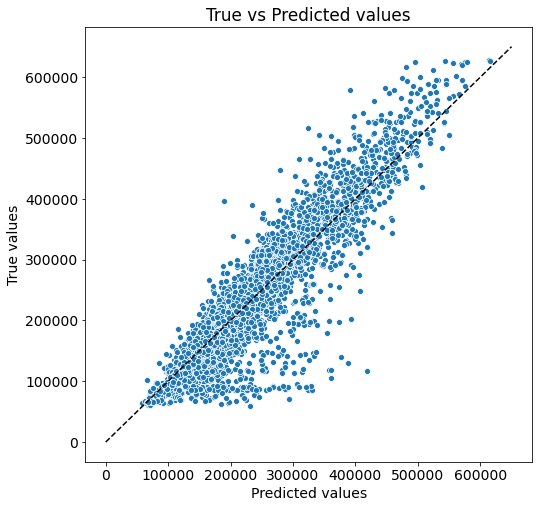

In [537]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=10,
                                        random_state=42,  
                                        n_estimators=100)

final_model.fit(X_train, y_train)

y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.74
RMSE:	47313.098
MSE:	2238529196.447


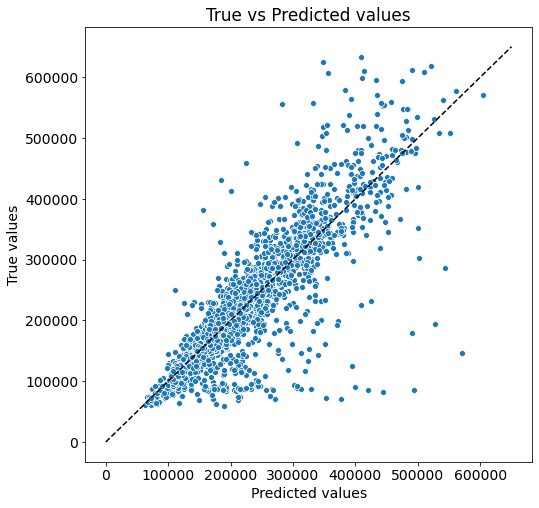

In [538]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds, save=False)

In [539]:
final_model.feature_importances_

array([3.88705683e-01, 5.38114012e-03, 2.58202254e-02, 4.64347065e-01,
       9.19982622e-03, 1.34625994e-02, 1.06030469e-02, 8.38428606e-03,
       2.16102442e-02, 2.91034251e-03, 9.80639050e-03, 9.24073719e-03,
       1.14289860e-02, 8.86981672e-03, 3.45377748e-03, 0.00000000e+00,
       0.00000000e+00, 1.74502787e-04, 4.64999921e-04, 8.13104686e-05,
       1.95966441e-04, 5.85905422e-03])

In [540]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [541]:
feature_importances.head(50)

,feature_name,importance
3,Square,0.464347
0,AverageSquareMeterPrice,0.388706
2,Rooms,0.025820
8,HouseYear,0.021610
5,KitchenSquare,0.013463
12,Social_2,0.011429
6,Floor,0.010603
10,Ecology_1,0.009806
11,Social_1,0.009241
4,LifeSquare,0.009200


In [170]:
feature_importances.tail(5)

,feature_name,importance
17,Ecology_3_A,0.000244
16,Ecology_2_B,0.000170
19,Shops_2_A,0.000122
15,Ecology_2_A,0.000086
20,Shops_2_B,0.000000


In [171]:
feature_final = feature_importances.loc[feature_importances['importance'] > 0.01]

In [ ]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [542]:
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X_final.set_index('Id', inplace=True)
X_final = X_final[feature_names]

In [543]:
X_final.T

Id,725,15856,5480,15664,14275,7633,13329,5502,4220,11538,...,15706,2105,7220,14562,6836,8180,4695,5783,4780,12504
AverageSquareMeterPrice,3021.675049,3355.343018,7919.443359,4116.345215,2766.023193,4835.401367,2284.108643,5008.861816,3987.220459,2905.762939,...,4194.537109,5109.482422,3987.220459,4491.922852,4089.011230,4055.974854,3212.333984,4106.496094,2818.749268,2849.414551
DistrictId_counts,179.000000,114.000000,7.000000,97.000000,851.000000,174.000000,565.000000,34.000000,71.000000,511.000000,...,89.000000,28.000000,71.000000,41.000000,57.000000,129.000000,652.000000,64.000000,247.000000,228.000000
Rooms,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,...,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,1.000000,3.000000,2.000000,2.000000
Square,49.882645,69.263184,15.000000,73.046608,47.527111,40.675625,68.099541,48.193897,72.277107,80.219398,...,47.776485,45.493240,80.182495,46.627884,45.131283,67.133911,40.198471,77.842178,81.305222,60.555695
LifeSquare,33.432781,32.781261,15.948246,51.940842,43.387569,32.781261,64.843025,32.857643,45.968758,47.660259,...,27.920874,32.022564,48.627327,27.058739,30.780550,50.809795,21.807060,48.282623,32.781261,32.781261
KitchenSquare,6.000000,3.000000,12.000000,9.000000,3.000000,3.000000,3.000000,6.000000,9.000000,9.000000,...,6.000000,6.000000,10.000000,5.000000,6.000000,6.000000,10.000000,9.000000,3.000000,3.000000
Floor,6.000000,6.000000,2.000000,22.000000,17.000000,21.000000,2.000000,5.000000,17.000000,13.000000,...,8.000000,4.000000,10.000000,6.000000,2.000000,5.000000,12.000000,23.000000,4.000000,10.000000
HouseFloor,14.000000,1.000000,5.000000,22.000000,17.000000,21.000000,17.000000,14.000000,17.000000,17.000000,...,9.000000,9.000000,17.000000,5.000000,5.000000,9.000000,17.000000,22.000000,1.000000,17.000000
HouseYear,1972.000000,1977.000000,1909.000000,2007.000000,2017.000000,1977.000000,1977.000000,1972.000000,1997.000000,2014.000000,...,1970.000000,1974.000000,2003.000000,1969.000000,1965.000000,1973.000000,2017.000000,1989.000000,1977.000000,1977.000000
Helthcare_2,0.000000,0.000000,5.000000,3.000000,0.000000,1.000000,0.000000,3.000000,1.000000,0.000000,...,0.000000,3.000000,1.000000,2.000000,0.000000,1.000000,0.000000,5.000000,0.000000,3.000000


In [544]:
y_pred_final = final_model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False, encoding='utf-8', sep=',')

preds_final.head()

,Id,Price
0,725,161605.215763
1,15856,209933.378985
2,5480,294757.212159
3,15664,337384.707743
4,14275,138712.432909
